# An Exclusive Guide to Exclusion Limits

In this notebook we will place exclusion limits using Python, it's the companion piece to an an introduction to exclusion limits we wrote that explains the theory and idea behind them. We will be restricting ourselves to use basic numerical packages such as numpy, scipy and matplotlib for visualisation, and the first step is to import them.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, norm, chi2
from scipy.optimize import minimize, brentq

We need something to place a limit on, and in our first example we are looking for a bump in an otherwise smooth background. This could be a gamma-ray line from dark matter annihilation, or maybe a particle resonance at the LHC. 

In this first toy example we keep the shape of the background, the width, and position of the signal bump are all fixed. The two parameters are then the normalisations of the signal bump and the smooth background.

Futhermore we define the data to be a measured number of events in $n=30$ energy bins, and define a data generating function with the signal spectra being a Gaussian at $E = 10$ and with a variance $\sigma^2 = 2$. The background is a power law with an index $-1$.

In [3]:
E = np.logspace(0,2,30+1)
E = (E[1:] + E[:-1]) / 2 # bin centers

def signal_shape(E=E, mu=10, var=2):
    return norm.pdf(E, mu, var)

def background_shape(E=E, gamma=-1):
    return E**gamma

def generate_data(bkg_norm, sig_norm, E=E, seed=None):
    np.random.seed(seed)
    return np.random.poisson(sig_norm * signal_shape(E) + 
                             bkg_norm * background_shape(E))

We define a function to visualise two realisations of this model.

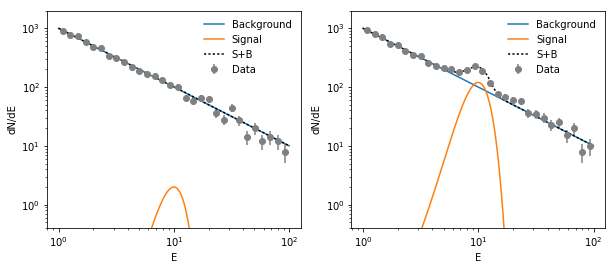

In [53]:
def visualise_model(bkg_norm, sig_norm, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    x = np.logspace(0,2,200)
    b = bkg_norm*background_shape(x)
    s = sig_norm*signal_shape(x)
    ax.plot(x, b, label='Background')
    ax.plot(x, s, label='Signal')
    ax.plot(x, s+b, color='black', linestyle='dotted', label='S+B')

    N = generate_data(bkg_norm, sig_norm)
    ax.errorbar(E, N, yerr=np.sqrt(N), fmt='o', color='grey', label='Data')
    ax.set_ylim(0.4, 2*np.maximum(s.max(), b.max()))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('E')
    ax.set_ylabel('dN/dE')
    ax.set_title(title)
    ax.legend(frameon=False)
    return N
    
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
data_small_sig = visualise_model(bkg_norm=1000, sig_norm=10, ax=axes[0], title='Small signal');
data_large_sig = visualise_model(bkg_norm=1000, sig_norm=600, ax=axes[1], title='Large signal');

On the left the signal is buried below the background and is completely invisibl, and placing an upper exclusion limit on the signal normalisation $\theta_s$ would be natural. In the right panel however the signal is large enough to be visible in the data, and an upper limit would not be the thing to do.

## Defining the likelihood and the test statistic

The likelihood $\mathcal{L}(\theta_s, \theta_b \,|\, D)$ is simply the product of poisson distributions for each bin. We define and work with the $\ln \mathcal{L}$ as it behaves better numerically better.

In [25]:
def lnLike(bkg_norm, sig_norm, data, gamma=-1, mu=10, var=2):
    s = sig_norm*signal_shape(mu=mu, var=var)
    b = bkg_norm*background_shape(gamma=gamma)
    return np.log(poisson.pmf(data, mu=s+b)).sum()

Our test statistic of choice is the logarithm of the maximum likelihood ratio which we defined as 

$$ \mathrm{TS}(\theta) = -2 \ln \frac{\max_{\nu} \mathcal{L}( \theta, \nu \,|\, D)}{\max_{\theta, \nu} \mathcal{L}( \theta, \nu \,|\, D)}$$

where $\theta$ are the parameter(s) we want to constrain, and $\nu$ are the remained. So if we wanted to constrain the normalisation of the signal $\theta_s$ the test statistic to consider is

$$ \mathrm{TS}(\theta_s) = -2 \ln \frac{\max_{\theta_b} \mathcal{L}( \theta_s, \theta_b \,|\, D)}{\max_{\theta_s, \theta_b} \mathcal{L}( \theta_s, \theta_b \,|\, D)}$$

In [26]:
def TS_sig(sig_norm, data, bestfit=None):
    numerator = minimize(lambda b: -2*lnLike(b, sig_norm, data), 1e3)
    if not bestfit:
        bestfit = minimize(lambda x: -2*lnLike(x[0], x[1], data), (1e3,1e3))
    return numerator.fun - bestfit.fun

The optional bestfit arguments is to spare us the burden of finding the minima everytime we evaluate the test statistic. As always, it is useful to visualise, and as examples we take the two realisations we already plotted.

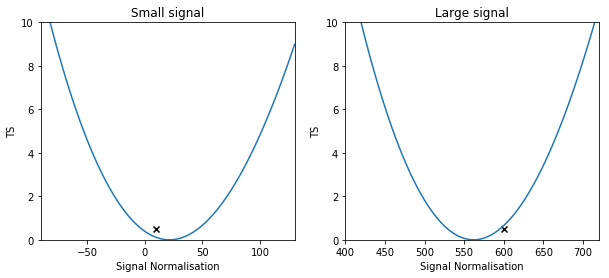

In [90]:
def visualise_TS_sig(data, siglim=(0, 1000), ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
   
    bestfit = minimize(lambda x: -2*lnLike(x[0], x[1], data), (1e3,1e3))
    x = np.linspace(*siglim, 100)
    ts = np.array([TS_sig(s, data, bestfit=bestfit) for s in x])
    ax.plot(x, ts)
    ax.set_ylim(0,10)
    ax.set_xlim(*siglim)
    
    ax.set_title(title)
    ax.set_xlabel('Signal Normalisation')
    ax.set_ylabel('TS')

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
visualise_TS_sig(data_small_sig, siglim=(-90,130), ax=axes[0], title='Small signal')
axes[0].scatter(10, 0.5, color='black', marker='x')
visualise_TS_sig(data_large_sig, siglim=(400,720), ax=axes[1], title='Large signal');
axes[1].scatter(600, 0.5, color='black', marker='x');

Where the black x marks the true parameter values of each of the data sets. We see that the test statistic is small in the region of the true values, not perfectly so as we have statistical noise.

We can also consider the full 2D case where 

$$ \mathrm{TS}(\theta_s, \theta_b) = -2 \ln \frac{ \mathcal{L}( \theta_s, \theta_b \,|\, D)}{\max_{\theta_s, \theta_b} \mathcal{L}( \theta_s, \theta_b \,|\, D)}$$

which is simply the likelihood normalised to it's maximum.

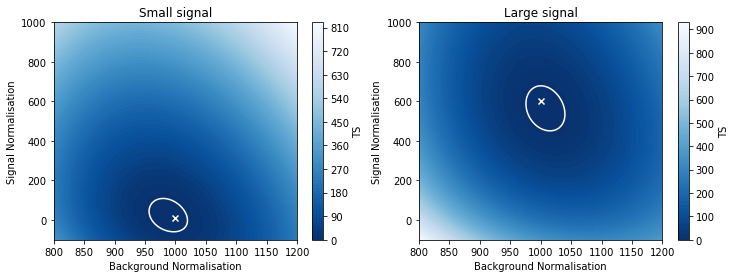

In [108]:
def TS_2d(bkg_norm, sig_norm, data, bestfit=None):
    numerator = -2*lnLike(bkg_norm, sig_norm, data)
    if not bestfit:
        bestfit = minimize(lambda x: -2*lnLike(x[0], x[1], data), (1e3,1e3))
    return numerator - bestfit.fun

def visualise_TS_2d(data, siglim=(-100, 1000), bkglim=(800,1200), ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    bestfit = minimize(lambda x: -2*lnLike(x[0], x[1], data), (1e3,1e3))
    
    bkg_norms = np.linspace(*bkglim, 100)
    sig_norms = np.linspace(*siglim, 100)
    ts = [[TS_2d(b, s, data, bestfit=bestfit) for s in sig_norms] for b in bkg_norms]
    X, Y = np.meshgrid(bkg_norms, sig_norms)
    Z = np.array(ts).T

    r = ax.contourf(X, Y, Z, 100, cmap='Blues_r')
    plt.colorbar(r, label='TS', ax=ax)
    ax.contour(X, Y, Z, colors='white', levels=[5.991])
    
    ax.set_xlim(*bkglim)
    ax.set_ylim(*siglim)
    
    ax.set_xlabel('Background Normalisation')
    ax.set_ylabel('Signal Normalisation')
    ax.set_title(title)

fig, axes = plt.subplots(ncols=2, figsize=(12,4))
visualise_TS_2d(data_small_sig, ax=axes[0], title='Small signal')
axes[0].scatter(1000, 10, color='white', marker='x')
visualise_TS_2d(data_large_sig, ax=axes[1], title='Large signal')
axes[1].scatter(1000, 600, color='white', marker='x');

where the white x marks the true parameter values of each of the data sets. We see that, as expected, the test statistic is smaller closer to the true value.

The white contour is simply us moving ahead of ourselves and plotting the $95.4$% confidence limit region using Wilks' theorem, i.e. by assuming that our TS is distributed as $\chi^2_{k=2}$. Ignore this for now.

## Confidence Intervals

From the visualisation of the test statistics above we see that they are deep valleys close to the true values. This can be used to construct confidence intervals. The interval is simply

$$\{\, \theta \, | \, \mathrm{TS}(\theta) < c \, \}$$

where $c$ is a threshold value such that we have the desired coverage. To determine $c$ we need to know how the test statistic is distributed under the null, i.e. when $\theta$ is the true value. If it applies, Wilks' theorem states that it's asymptotically chi-squared distributed with as many degrees of freedom $k$ as parameters of interest. So for 1D and 2D we can compute

In [103]:
from functools import partial 

def threshold(cl, cdf):
    return brentq(lambda x: cl-cdf(x), 0, 10)

threshold_1d = partial(threshold, cdf=partial(chi2.cdf, df=1))
threshold_2d = partial(threshold, cdf=partial(chi2.cdf, df=2))

print('68%% and 95%% thresholds for 1D: %.3f and %.3f' 
      % tuple([threshold_1d(x) for x in [0.68, 0.95]]))
print('68%% and 95%% thresholds for 2D: %.3f and %.3f' 
      % tuple([threshold_2d(x) for x in [0.68, 0.95]]))

68% and 95% thresholds for 1D: 0.989 and 3.841
68% and 95% thresholds for 2D: 2.279 and 5.991


With this we can now find the 68% CL intervals of $\theta_s$ for our two examples.

In [105]:
def confidence_interval(data, bestfit=None, CL=0.68):
    if not bestfit:
        bestfit = minimize(lambda x: -2*lnLike(x[0], x[1], data), (1e3,1e3))
    
    ts = TS_sig
    threshold = threshold_1d(CL)
    
    # Simple way to find starting points for the root finder.
    # We need (a, b) for which TS-ts_threshold have different sign.
    step = 10+bestfit.x[1]/2
    u = bestfit.x[1] + step

    while ts(u, data, bestfit=bestfit) <= threshold:
        u += step

    # The TS tend to be symmetrical which we can use to do a better initial guess.
    l = 2*bestfit.x[1] - u
    while ts(l, data, bestfit=bestfit) <= threshold:
        l -= step
        
    upper_bound = brentq(lambda x: ts(x, data, bestfit=bestfit) - threshold,
                         bestfit.x[1], u)

    lower_bound = brentq(lambda x: ts(x, data, bestfit=bestfit) - threshold,
                         l, bestfit.x[1])
    
    return lower_bound, upper_bound

print(confidence_interval(data_small_sig))
print(confidence_interval(data_large_sig))

(-12.312692543729467, 56.3249098510842)
(516.0588694183307, 608.7210610867332)


### Check coverage

To check if our procedure work we will do a 100 experiments and see if the true value are covered at the correct frequency, e.g. 68ish times if we want 68% CL.

In [107]:
def coverage_check(sig_norm, CL=0.68, bkg_norm=1000, n=100):
    covered = 0
    for _ in range(n):
        d = generate_data(bkg_norm, sig_norm)
        l, u = confidence_interval(d, CL=CL)
        if l < sig_norm and u > sig_norm:
            covered += 1

    return covered/n

print('Coverage small signal: %.3f' % coverage_check(10))
print('Coverage large signal: %.3f' % coverage_check(600))

/Users/sliem/.miniconda3/lib/python3.5/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Coverage small signal: 0.610
Coverage large signal: 0.640


Not bad, with more experiments this should be better. Try it yourself!

## Verifying that Wilk's theorem applies

We can verify that our test statistic is $\chi^2_{k=1}$ distributed by doing monte carlo experiments. We can then compare the empirical distribution with the chi-squared one.

In [111]:
def mc(sig_norm, bkg_norm=1000, n=100):
    ts = []
    for _ in range(n):
        d = generate_data(bkg_norm, sig_norm)
        bf = minimize(lambda x: -2*lnLike(x[0], x[1], d), (1e3,1e3))
        ts.append(minimize(lambda s: TS_sig(s, d, bestfit=bf), sig_norm).fun)

    return np.array(ts)

In [112]:
mc_small_signal = mc(sig_norm=10)

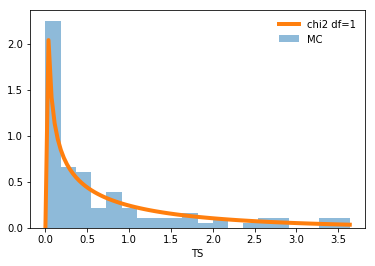

In [119]:
x = np.linspace(np.min(mc_small_signal), np.max(mc_small_signal), 100)
plt.hist(mc_small_signal, bins=20, normed=True, alpha=0.5, label='MC')
plt.plot(x, chi2.pdf(x, df=1), lw=4, label='chi2 df=1')
plt.legend(frameon=False)
plt.xlabel('TS')

## Upper Limits

We've seen how the the maximum likelihood test statistic leads to two sided intervals, but our aim is to do exclusion limits. We modify our test statistic as follows.

$$\mathrm{TS}(\theta_s) =
\begin{cases}
  \mathrm{TS}(\theta_s) & \quad \theta_s \geq \hat{\theta_s}\\
  0 & \quad \text{elsewise}\\
\end{cases}
$$

This is for a upper limit on $\theta_s$.

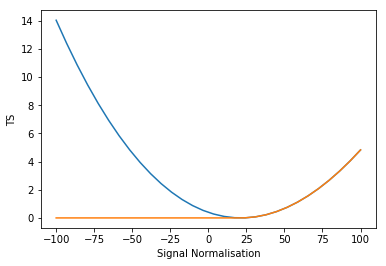

In [130]:
def TS_upper_limit(sig_norm, data, bestfit=None):
    if not bestfit:
        bestfit = minimize(lambda x: -2*lnLike(x[0], x[1], data), (1e3,1e3))
        
    if sig_norm < bestfit.x[1]:
        return 0.0
    else:
        return TS_sig(sig_norm, data, bestfit=bestfit)
    
bestfit = minimize(lambda x: -2*lnLike(x[0], x[1], data_small_sig), (1e3,1e3))
x = np.linspace(-100, 100, 30)
y = [TS_sig(s, data_small_sig, bestfit=bestfit) for s in x]

plt.plot(x, y);
y = [TS_upper_limit(s, data_small_sig, bestfit=bestfit) for s in x]
plt.plot(x, y)
plt.xlabel('Signal Normalisation')
plt.ylabel('TS');

This is now distributed as 

$$\mathrm{TS}_{\mathrm{ul}} \sim \frac{1}{2}\delta(0) + \frac{1}{2} \chi^2_{\mathrm{df}=1}$$

from this expression we can determine the required threshold for various confidence levels. Again the threshold for a $100n$ confidence level is simply

$$ \mathrm{CDF}(x) = n $$

In [131]:
threshold_ul = partial(threshold, cdf = lambda x: 0.5 + 0.5*chi2.cdf(x, df=1))
print('Threshold for 90%% CL upper limit: %.3f' % threshold_ul(0.90))

Threshold for 90% CL upper limit: 1.642


We can now use a root finder to find for which $\theta_s$ our new TS has this threshold value, and this is our upper limit!

In [136]:
def upper_limit(data, bestfit=None, CL=0.90):
    if not bestfit:
        bestfit = minimize(lambda x: -2*lnLike(x[0], x[1], data), (1e3,1e3))
    threshold = threshold_ul(CL)
    return brentq(lambda x: TS_upper_limit(x, data, bestfit=bestfit)-threshold, 
                  -1000, 1000)

print('90%% CL upper limit for small signal: %.2f' % upper_limit(data_small_sig))
print('90%% CL upper limit for large signal: %.2f' % upper_limit(data_large_sig))

90% CL upper limit for small signal: 66.60
90% CL upper limit for large signal: 622.45


### Check coverage for the upper limit

We perform a multitude of 'experiments' and investigate if the upper limit covers the true value as often as it should.

In [138]:
def coverage_check_ul(sig_norm, CL=0.90, bkg_norm=1000, n=100):
    upper_limits = []
    for _ in range(n):
        d = generate_data(bkg_norm, sig_norm)
        upper_limits.append(upper_limit(d, CL=CL))
        
    upper_limits = np.array(upper_limits)
    not_excluded = (upper_limits >= sig_norm).sum()
    
    return not_excluded/n

print('Coverage small signal: %.3f' % coverage_check_ul(10))
print('Coverage large signal: %.3f' % coverage_check_ul(600))

/Users/sliem/.miniconda3/lib/python3.5/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Coverage small signal: 0.910


/Users/sliem/.miniconda3/lib/python3.5/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Coverage large signal: 0.900


# TODO

- Extend the problem by letting the bump position vary.
- Make brazil plot